# U-Net Model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os, cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-12-06 07:53:30.586423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Loading

In [2]:
IMG_DIR = "/Users/anugrahrastogi21gmail.com/Downloads/archive (3)/data/Lung Segmentation/CXR_png/"
MASK_DIR = "/Users/anugrahrastogi21gmail.com/Downloads/archive (3)/data/Lung Segmentation/masks/"
IMG_H, IMG_W = 256, 256

def load_data():
    X = []
    y = []

    if not os.path.isdir(IMG_DIR):
        print("⚠ Update IMAGE/MASK paths")
        return np.zeros((1, IMG_H, IMG_W, 3)), np.zeros((1, IMG_H, IMG_W, 1))

    for f in os.listdir(IMG_DIR):
        ip = os.path.join(IMG_DIR, f)
        mp = os.path.join(MASK_DIR, f)

        if not os.path.exists(mp):
            continue

        img = cv2.imread(ip)
        mask = cv2.imread(mp, 0)

        if img is None or mask is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_W, IMG_H)) / 255.0

        mask = cv2.resize(mask, (IMG_W, IMG_H)) / 255.0

        X.append(img)
        y.append(mask[..., None])

    return np.array(X), np.array(y)


X, y = load_data()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Data Augmentation

In [3]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


# Dice Loss

In [4]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    inter = tf.reduce_sum(y_true * y_pred)
    
    return 1 - (2 * inter + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )


# Improved U-Net

In [5]:
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(f, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def unet():
    inp = layers.Input((IMG_H, IMG_W, 3))
    x = data_aug(inp)

    c1 = conv_block(x, 64)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D()(c4)

    bn = conv_block(p4, 1024)

    u4 = layers.UpSampling2D()(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, 512)

    u3 = layers.UpSampling2D()(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 256)

    u2 = layers.UpSampling2D()(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 128)

    u1 = layers.UpSampling2D()(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 64)

    out = layers.Conv2D(1, 1, activation='sigmoid')(c8)

    model = models.Model(inp, out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=lambda a, b: 0.5 * tf.keras.losses.binary_crossentropy(a, b) +
                         0.5 * dice_loss(a, b),
        metrics=['accuracy']
    )

    return model


model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                               

# Training

In [6]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_unet.h5",
        save_best_only=True,
        monitor="val_loss"
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4
    )
]

if len(X_train) > 1:
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=4,
        validation_split=0.1,
        callbacks=callbacks
    )


Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7522

/Users/anugrahrastogi21gmail.com/Documents/opencv_project/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 165s 6s/step - loss: 0.5068 - accuracy: 0.7522 - val_loss: 0.6774 - val_accuracy: 0.3194 - lr: 1.0000e-04
Epoch 2/5
25/25 [==============================] - 166s 7s/step - loss: 0.3843 - accuracy: 0.8365 - val_loss: 0.7510 - val_accuracy: 0.2904 - lr: 1.0000e-04
Epoch 3/5
25/25 [==============================] - 162s 6s/step - loss: 0.3581 - accuracy: 0.8465 - val_loss: 0.6033 - val_accuracy: 0.6646 - lr: 1.0000e-04
Epoch 4/5
25/25 [==============================] - 175s 7s/step - loss: 0.3454 - accuracy: 0.8545 - val_loss: 0.5865 - val_accuracy: 0.6763 - lr: 1.0000e-04
Epoch 5/5
25/25 [==============================] - 176s 7s/step - loss: 0.3339 - accuracy: 0.8571 - val_loss: 0.5454 - val_accuracy: 0.7409 - lr: 1.0000e-04


# A & B: Train vs Test Accuracy Plot

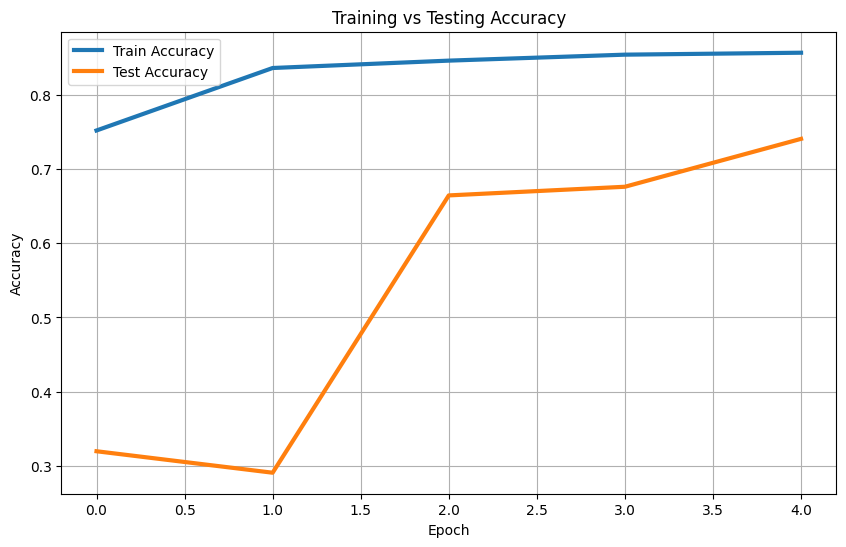

Final Train Accuracy: 0.857147216796875
Final Test Accuracy: 0.7409404516220093


In [7]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy',
linewidth=3)
plt.plot(history.history['val_accuracy'], label='Test Accuracy',
linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print("Final Train Accuracy:", history.history['accuracy'][-1])
print("Final Test Accuracy:", history.history['val_accuracy'][-1])

# Visualization

1/1 [==============================] - 1s 1s/step


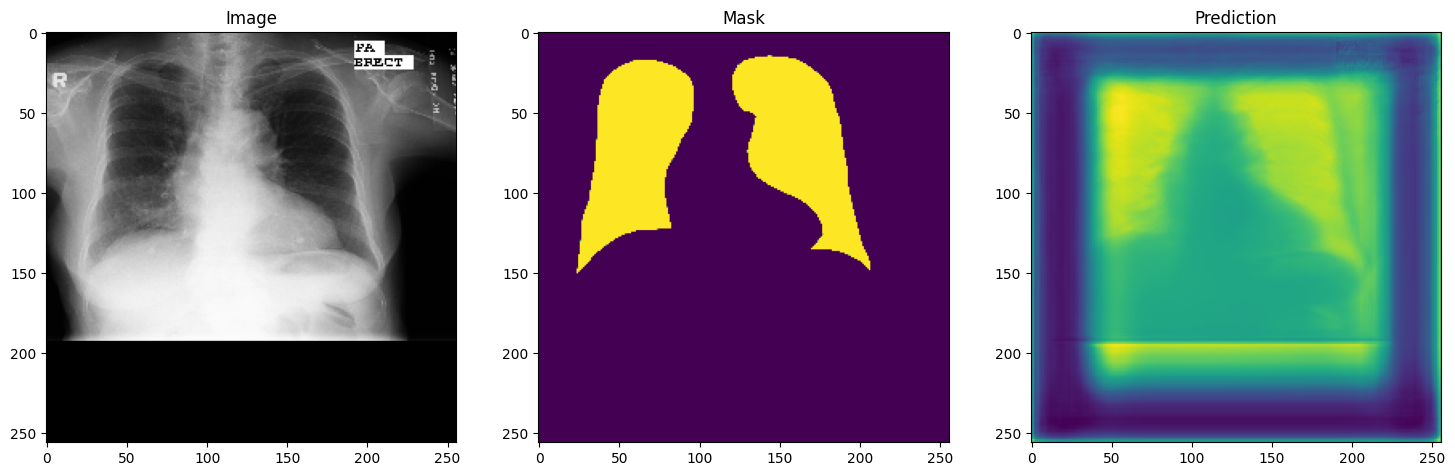

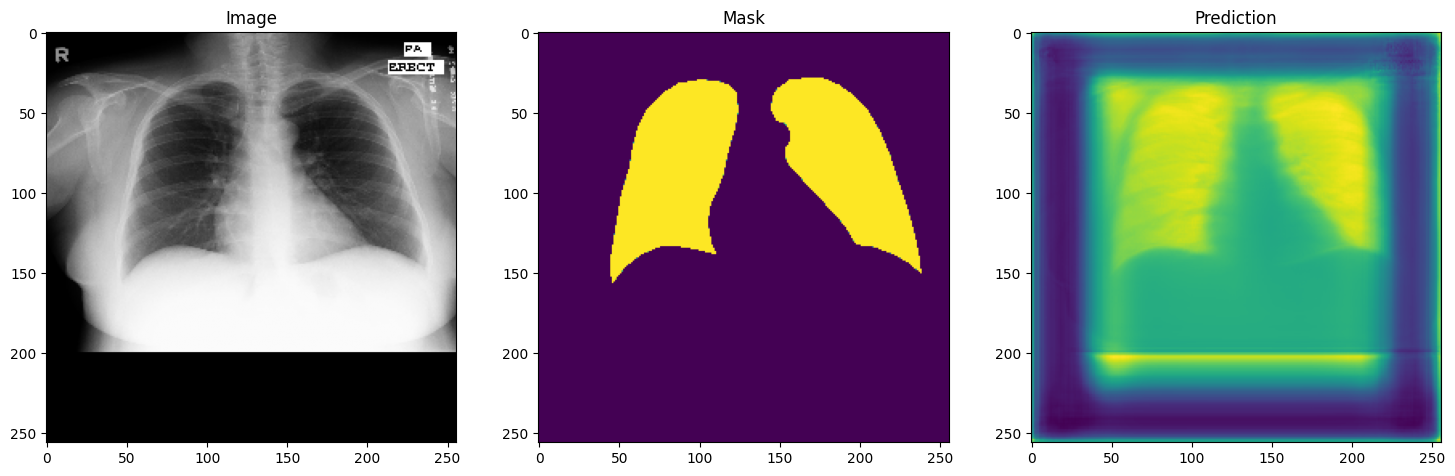

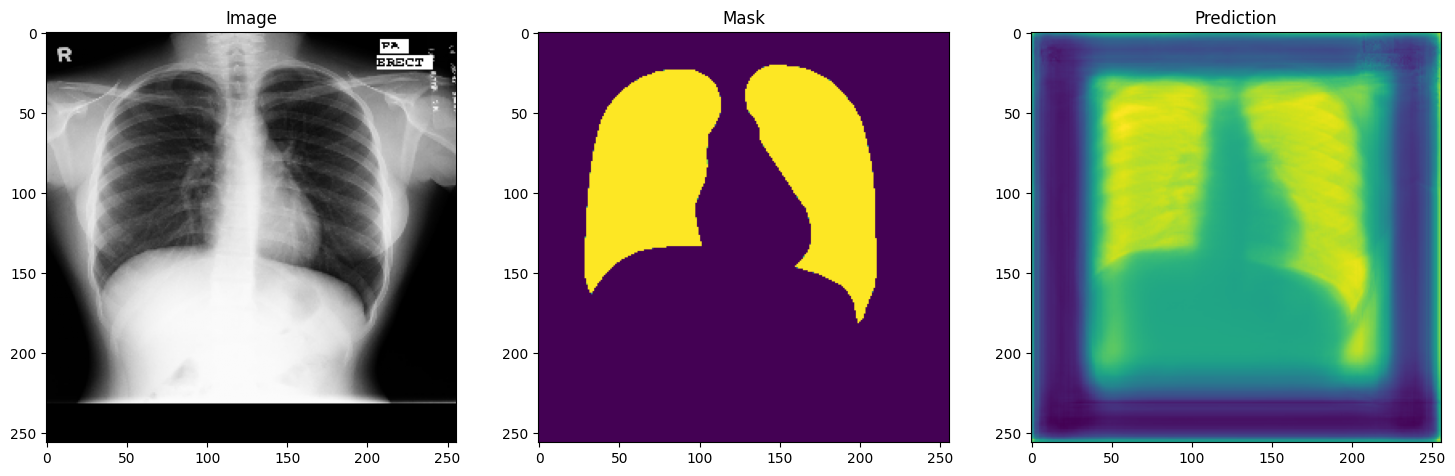

In [8]:
if len(X_test) > 1:
    model.load_weights("best_unet.h5")
    preds = model.predict(X_test[:3])

    for i in range(3):
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title("Image")

        plt.subplot(1, 3, 2)
        plt.imshow(y_test[i].squeeze())
        plt.title("Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze())
        plt.title("Prediction")

        plt.show()
